# Bayes Theorem & Naive Bayes Classifier

https://www.analyticsvidhya.com/blog/2019/06/introduction-powerful-bayes-theorem-data-science/

https://blog.paperspace.com/introduction-to-naive-bayes/

## 1. Introduction

### Import Libraries

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,roc_auc_score
import time
import pandas as pd

%matplotlib inline

## 1.1. Bayes Theorem

In [184]:
# calculate the probability of cancer patient and diagnostic test

# calculate P(A|B) given P(A), P(B|A), P(B|not A)
def bayes_theorem(p_a, p_b_given_a, p_b_given_not_a):
    # calculate P(not A)
    not_a = 1 - p_a
    # calculate P(B)
    p_b = p_b_given_a * p_a + p_b_given_not_a * not_a
    # calculate P(A|B)
    p_a_given_b = (p_b_given_a * p_a) / p_b
    return p_a_given_b

In [185]:
# Assigning features and label variables
weather = ['Sunny','Sunny','Overcast','Rainy','Rainy','Rainy','Overcast','Sunny','Sunny','Rainy','Sunny','Overcast','Overcast','Rainy']
temp = ['Hot','Hot','Hot','Mild','Cool','Cool','Cool','Mild','Cool','Mild','Mild','Mild','Hot','Mild']
play = ['No','No','Yes','Yes','Yes','No','Yes','No','Yes','Yes','Yes','Yes','Yes','No']

In [186]:
# Assigning features and label variables
family_struct = ['Nuclear','Extended','Childless','Childless','Single Parent','Childless','Nuclear','Nuclear','Extended','Single Parent']
age_group = ['Young','Old','Middle-aged','Young','Middle-aged','Young','Old','Middle-aged','Middle-aged','Old']
income = ['Low','Low','Low','Medium','Medium','Low','High','Medium','High','Low']
buy_car = ['Yes','No','No','Yes','Yes','No','Yes','Yes','Yes','No']

In [254]:
# dictionary of lists 
dict = {'weather': weather, 'temp': temp, 'play': play} 
dict = {'family_struct': family_struct,'age_group':age_group,'income':income,'buy_car':buy_car} 
    
df = pd.DataFrame(dict)
df.columns=list(df.columns[:-1])+['label']
#df = df.melt(id_vars=['buy_car'],var_name='features',value_name='value')
#df.columns=['label']+list(df.columns[1:])

In [255]:
df

,family_struct,age_group,income,label
0,Nuclear,Young,Low,Yes
1,Extended,Old,Low,No
2,Childless,Middle-aged,Low,No
3,Childless,Young,Medium,Yes
4,Single Parent,Middle-aged,Medium,Yes
5,Childless,Young,Low,No
6,Nuclear,Old,High,Yes
7,Nuclear,Middle-aged,Medium,Yes
8,Extended,Middle-aged,High,Yes
9,Single Parent,Old,Low,No


Count class probability

In [256]:
df_grp_lbl=df.groupby('label').count().reset_index()[['label','income']]
df_grp_lbl.columns=list(df_grp_lbl.columns[:-1])+['f_h']

In [257]:
df_grp_lbl

,label,f_h
0,No,4
1,Yes,6


Make Frequency Table

In [258]:
df_melt = df.melt(id_vars=['label'],var_name='features',value_name='value')
df_melt.columns=['label']+list(df_melt.columns[1:])

In [259]:
df_grp=df_melt.groupby(['label','features','value']).size().reset_index(name='count')
df_grp.columns=list(df_grp.columns[:-1])+['f_e_given_h']
#.reset_index()
df_grp[df_grp['value']=='Low'].head(5)

,label,features,value,f_e_given_h
6,No,income,Low,4
15,Yes,income,Low,1


In [491]:
df_a=df_grp.groupby((['features','value'])).count().reset_index()[['features','value']]
df_a['key']=1
df_b = df_grp_lbl
df_b['key']=1
df_feat=pd.merge(df_a, df_b, on ='key').drop("key", 1)

Join with frequency table

In [492]:
df_grp

,label,features,value,f_e_given_h
0,No,age_group,Middle-aged,1
1,No,age_group,Old,2
2,No,age_group,Young,1
3,No,family_struct,Childless,2
4,No,family_struct,Extended,1
5,No,family_struct,Single Parent,1
6,No,income,Low,4
7,Yes,age_group,Middle-aged,3
8,Yes,age_group,Old,1
9,Yes,age_group,Young,2


In [493]:
df_prob=df_feat.merge(df_grp,on=['label','features','value'],how='outer')
#df_prob=df_grp.merge(df_grp_lbl,on='label',how='outer')

In [496]:
df_prob['p_e_given_h']=df_prob['f_e_given_h']/df_prob['f_h']
df_prob['p_e_given_h']=df_prob['p_e_given_h'].fillna(0)

In [497]:
df_prob

,features,value,label,f_h,f_e_given_h,p_e_given_h
0,age_group,Middle-aged,No,4,1.0,0.250000
1,age_group,Middle-aged,Yes,6,3.0,0.500000
2,age_group,Old,No,4,2.0,0.500000
3,age_group,Old,Yes,6,1.0,0.166667
4,age_group,Young,No,4,1.0,0.250000
5,age_group,Young,Yes,6,2.0,0.333333
6,family_struct,Childless,No,4,2.0,0.500000
7,family_struct,Childless,Yes,6,1.0,0.166667
8,family_struct,Extended,No,4,1.0,0.250000
9,family_struct,Extended,Yes,6,1.0,0.166667


Inferencing Sample Data

In [549]:
df_ext=df_prob[(df_prob['value'].isin(['Single Parent','Young','Low']))]
df_ext=df_ext.groupby('label').agg({'p_e_given_h':np.prod}).reset_index()
df_ext.columns=['label','p_h']
df_ext['total_prob']=df_ext['p_h'].sum()
df_ext['norm_prob']=df_ext['p_h']/df_ext['total_prob']
#df_ext['norm_prob']=df_ext['.sum()']

In [550]:
df_ext

,label,p_h,total_prob,norm_prob
0,No,0.062500,0.071759,0.870968
1,Yes,0.009259,0.071759,0.129032


Inferencing training data

In [551]:
small_dfs = []
X=df[df.columns[:-1]]
for idx in range(len(X)):
    df_select = X.iloc[[idx]]
    df_ext=df_prob[df_prob['value'].isin(df_select.values[0])]
    df_ext=df_ext.groupby('label').agg({'p_e_given_h':np.prod}).reset_index()
    df_ext.columns=['label','p_h']
    df_ext['total_prob']=df_ext['p_h'].sum()
    df_ext['norm_prob']=df_ext['p_h']/df_ext['total_prob']
    df_select['prob_no']=df_ext[df_ext['label']=='No']['norm_prob'].values[0]
    df_select['prob_yes']=df_ext[df_ext['label']=='Yes']['norm_prob'].values[0]
    small_dfs.append(df_select)
    
df_infer = pd.concat(small_dfs, ignore_index=True)

<ipython-input-551-edee196b9567>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['prob_no']=df_ext[df_ext['label']=='No']['norm_prob'].values[0]
<ipython-input-551-edee196b9567>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['prob_yes']=df_ext[df_ext['label']=='Yes']['norm_prob'].values[0]


In [559]:
df.columns

Index(['family_struct', 'age_group', 'income', 'label'], dtype='object')

In [561]:
large_df.columns

Index(['family_struct', 'age_group', 'income', 'prob_no', 'prob_yes'], dtype='object')

In [583]:
df_result_manual=large_df.merge(df,on=['family_struct','age_group','income'])

### Implementation with Sk-Learn

In [573]:
df

,family_struct,age_group,income,label
0,Nuclear,Young,Low,Yes
1,Extended,Old,Low,No
2,Childless,Middle-aged,Low,No
3,Childless,Young,Medium,Yes
4,Single Parent,Middle-aged,Medium,Yes
5,Childless,Young,Low,No
6,Nuclear,Old,High,Yes
7,Nuclear,Middle-aged,Medium,Yes
8,Extended,Middle-aged,High,Yes
9,Single Parent,Old,Low,No


In [574]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

X = df[df.columns[:-1]]

In [575]:
enc.fit(X)
X_enc=enc.transform(X).toarray()

le = preprocessing.LabelEncoder()
label_encoded=le.fit_transform(df['label'])
print("Label:",label_encoded)

Label: [1 0 0 1 1 0 1 1 1 0]


In [576]:
# Import Gaussian Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

# Create a Gaussian Classifier
model = BernoulliNB()

# Train the model using the training sets
model.fit(X_enc,label_encoded)

BernoulliNB()

In [584]:
df_result_sklearn = df.copy()
df_result_sklearn['prob_no'] =  model.predict_proba(X_enc)[:,0]
df_result_sklearn['prob_yes'] =  model.predict_proba(X_enc)[:,1]
df_result_sklearn 

,family_struct,age_group,income,label,prob_no,prob_yes
0,Nuclear,Young,Low,Yes,0.406563,0.593437
1,Extended,Old,Low,No,0.948712,0.051288
2,Childless,Middle-aged,Low,No,0.860450,0.139550
3,Childless,Young,Medium,Yes,0.120508,0.879492
4,Single Parent,Middle-aged,Medium,Yes,0.039483,0.960517
5,Childless,Young,Low,No,0.911320,0.088680
6,Nuclear,Old,High,Yes,0.051960,0.948040
7,Nuclear,Middle-aged,Medium,Yes,0.005451,0.994549
8,Extended,Middle-aged,High,Yes,0.064117,0.935883
9,Single Parent,Old,Low,No,0.948712,0.051288


In [585]:
df_result_manual

,family_struct,age_group,income,prob_no,prob_yes,label
0,Nuclear,Young,Low,0.000000,1.000000,Yes
1,Extended,Old,Low,0.964286,0.035714,No
2,Childless,Middle-aged,Low,0.900000,0.100000,No
3,Childless,Young,Medium,0.000000,1.000000,Yes
4,Single Parent,Middle-aged,Medium,0.000000,1.000000,Yes
5,Childless,Young,Low,0.931034,0.068966,No
6,Nuclear,Old,High,0.000000,1.000000,Yes
7,Nuclear,Middle-aged,Medium,0.000000,1.000000,Yes
8,Extended,Middle-aged,High,0.000000,1.000000,Yes
9,Single Parent,Old,Low,0.964286,0.035714,No


## 2. Analysis on Sample Data

### 2.1. Numerical Columns

Generate sample data

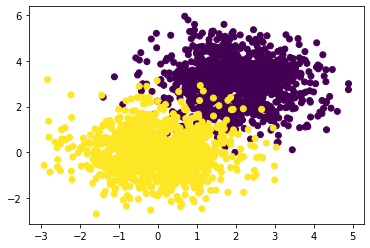

In [11]:
mean1 = (2, 3)
cov1 = [[1, 0], [0, 1]]
data_1 = np.random.multivariate_normal(mean1, cov1, (1000))

mean2 = (0, 0)
cov2 = [[1, 0], [0, 1]]
data_2 = np.random.multivariate_normal(mean2, cov2, (1000))

X=np.vstack([data_1,data_2])
y = np.hstack([[1]*len(data_1),[2]*len(data_2)])
X,y=make_circles(n_samples=500,noise=0.2, factor=0.4, random_state=1)
plt.scatter(X[:,0],X[:,1],c=y)
#clf_2,loss_values_2=train_model(X,y)
#plt.xlabel('X')
#plt.ylabel('Y')

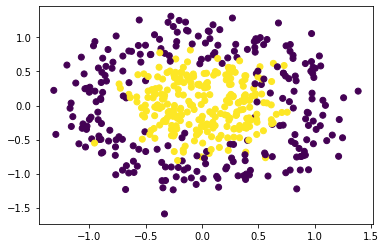

In [50]:
plt.scatter(X[:,0],X[:,1],c=y)

In [15]:
gnb = GaussianNB()
model_gnb = gnb.fit(X, y)

In [19]:
gnb.predict_proba

<bound method _BaseNB.predict_proba of GaussianNB()>

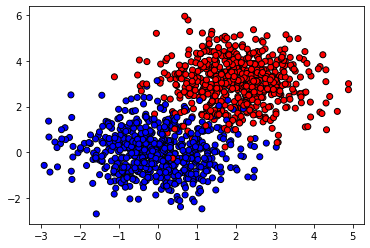

In [34]:
h = .02  # step size in the mesh

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# just plot the dataset first
cm = plt.cm.RdBu 
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1,1, 1)
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')

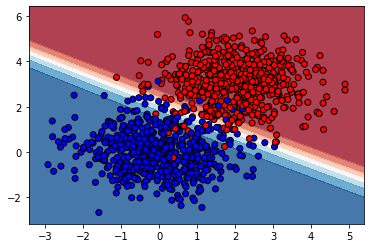

In [37]:
Z = gnb.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
ax = plt.subplot(1,1,1)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
plt.show()

In [ ]:
# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    if ds_cnt == 0:
        ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1


## Text Data

In [8]:
df=pd.read_csv('Twitter_Data.csv')

In [14]:
print(df.shape)
df.head(5)

(162980, 2)


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [17]:
df_ext=df[df['category'].isin([-1,1])]

In [18]:
print(df_ext.shape)
df_ext.head(5)

(107760, 2)


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
8,with upcoming election india saga going import...,1.0


In [25]:
print(df_ext.dtypes)

clean_text     object
category      float64
dtype: object


In [22]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\madin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [32]:
stop = stopwords.words('english')
df_ext['cleaned']=df_ext['clean_text'].apply(lambda x: [item for item in str(x).split(" ") if str(item) not in stop])

<ipython-input-32-ac6d812418f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ext['cleaned']=df_ext['clean_text'].apply(lambda x: [item for item in str(x).split(" ") if str(item) not in stop])


In [33]:
df_ext.head(5)

,clean_text,category,cleaned
0,when modi promised “minimum government maximum...,-1.0,"[modi, promised, “minimum, government, maximum..."
2,what did just say vote for modi welcome bjp t...,1.0,"[say, vote, modi, , welcome, bjp, told, rahul,..."
3,asking his supporters prefix chowkidar their n...,1.0,"[asking, supporters, prefix, chowkidar, names,..."
4,answer who among these the most powerful world...,1.0,"[answer, among, powerful, world, leader, today..."
8,with upcoming election india saga going import...,1.0,"[upcoming, election, india, saga, going, impor..."


In [7]:
# calculate the probability of cancer patient and diagnostic test

# calculate P(A|B) given P(A), P(B|A), P(B|not A)
def bayes_theorem(p_a, p_b_given_a, p_b_given_not_a):
    # calculate P(not A)
    not_a = 1 - p_a
    # calculate P(B)
    p_b = p_b_given_a * p_a + p_b_given_not_a * not_a
    # calculate P(A|B)
    p_a_given_b = (p_b_given_a * p_a) / p_b
    return p_a_given_b

# P(A)
p_a = 0.0002
# P(B|A)
p_b_given_a = 0.85
# P(B|not A)
p_b_given_not_a = 0.05
# calculate P(A|B)
result = bayes_theorem(p_a, p_b_given_a, p_b_given_not_a)
# summarize
print('P(A) = {0}%'.format(p_a*100) )
print('P(B|A) = {0}%'.format(p_b_given_a*100) )
print('P(B|not A) = {0}%'.format(p_b_given_not_a*100) )
print('P(A|B) = %.3f%%' % (result * 100))

P(A) = 0.02%
P(B|A) = 85.0%
P(B|not A) = 5.0%
P(A|B) = 0.339%


In [7]:
x1_centers = [0,0,2]
x2_centers = [0,2,0]
num_data = 50

datas = []
for i in range(0,len(x1_centers)):
    datas.append(generate_sample(x1_centers[i],x2_centers[i],1.5,num_data))
    
X = np.vstack(datas)
y = list(np.hstack([[1] * num_data,[2] * num_data,[3] * num_data]))

(-2.0, 4.0)

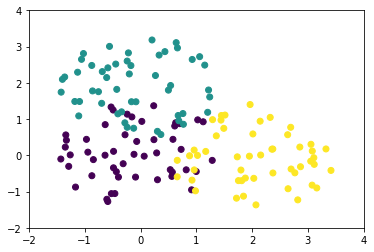

In [8]:
plt.scatter(X[:,0],X[:,1],c=y)
plt.xlim(-2,4);plt.ylim(-2,4)

Initialize kNN Classifier

In [20]:
neigh = NearestNeighbors(n_neighbors=15)
neigh.fit(X,y)

NearestNeighbors(n_neighbors=15)

In [21]:
X_sample = np.array(([0,1],[1,0]))

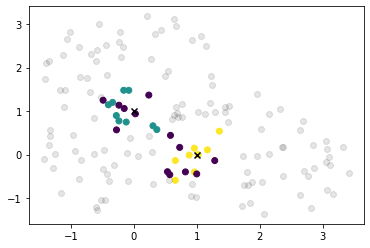

In [22]:
neighbors=neigh.kneighbors(X_sample)
id_arr = neighbors[1]
id_arr = id_arr.flatten().tolist()

arr =  X[id_arr]
y = np.array(y)
arr_y = y[id_arr]
arr_ex = np.array([element for i, element in enumerate(X) if i not in id_arr])

plt.scatter(arr[:,0],arr[:,1],c=arr_y)
plt.scatter(X_sample[:,0],X_sample[:,1],marker='x',c='k')
plt.scatter(arr_ex[:,0],arr_ex[:,1],c='k',alpha=0.1)

In [23]:
neighbors[0]

array([[0.06779211, 0.16636154, 0.27547657, 0.28085443, 0.29913234,
        0.32964258, 0.39466539, 0.43183884, 0.43722765, 0.45374253,
        0.48493271, 0.5056799 , 0.51423694, 0.55053994, 0.56026269],
       [0.02086188, 0.12211008, 0.15053439, 0.19965962, 0.31708292,
        0.31846622, 0.36881271, 0.40460507, 0.43935814, 0.44712261,
        0.60845977, 0.61248631, 0.63297699, 0.64557221, 0.68525139]])

As we see, there are data points that are closer to our sample points compared to other neighbors. Currently, those close data points will have the same vote weight as the one that is farther. We can modify this charactheristic by using euclidean distance as weight factor on majority vote to reflect that closer data points have closer resemblance.

In [24]:
np.array(arr_ex).shape

(120, 2)

### Effect of distance functions

We can use different type of distances function, which may results to different nearest neighbors. For example, let's try using 4 different distances type:  
- Euclidean 
- Minkowski
- Manhattan
- Mahalanobis

C:\Users\madin\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1460: FutureWarning: from version 0.25, pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  warnings.warn("from version 0.25, pairwise_distances for "


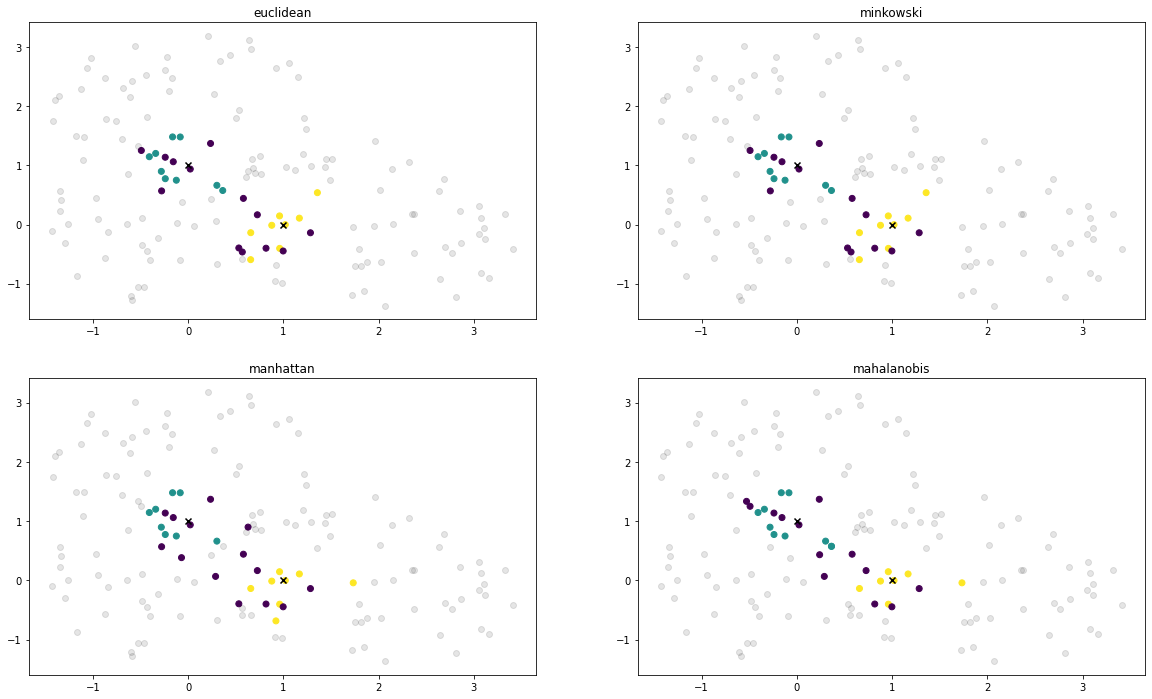

In [41]:
metrictypes=['euclidean','minkowski','manhattan','mahalanobis']
fig, axs = plt.subplots(int(len(metrictypes)/2), 2, figsize=(20, 12))
for i,metrictype in enumerate(metrictypes):
    if(metrictype=='mahalanobis'):
        neigh = NearestNeighbors(n_neighbors=15,algorithm='brute', metric=metrictype,metric_params={'V': np.cov(X)})
    else:
        neigh = NearestNeighbors(n_neighbors=15,metric=metrictype)
    neigh.fit(X,y)
    neighbors=neigh.kneighbors(X_sample)
    id_arr = neighbors[1]
    id_arr = id_arr.flatten().tolist()

    arr =  X[id_arr]
    y = np.array(y)
    arr_y = y[id_arr]
    arr_ex = np.array([element for i, element in enumerate(X) if i not in id_arr])

    axs[int(i/2),i%2].scatter(arr[:,0],arr[:,1],c=arr_y)
    axs[int(i/2),i%2].scatter(X_sample[:,0],X_sample[:,1],marker='x',c='k')
    axs[int(i/2),i%2].scatter(arr_ex[:,0],arr_ex[:,1],c='k',alpha=0.1)
    axs[int(i/2),i%2].set_title(metrictype)

We can see there are changes at the edges point due to how the distance calculated differently

## 3. Usage on real data

Let's try to use KNN Classifier on real world data. Here we have data of usage of fresh product, milk, groceries, frozens, detergents and peper, and delicassen, and whether they are hotels or restaurants. Our objective is to determine with records of these consumables we know whether that is a hotel or restaurant.

In [42]:
df = pd.read_csv('Wholesale customers data.csv')

In [43]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Select features

In [75]:
X = df[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']].to_numpy()
y = df[['Channel']].to_numpy().ravel()-1

Split train-test

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Normalize feautures

In [77]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [78]:
X_train=scaler.transform(X_train)

Train model

In [79]:
time_now = time.time()
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train,y_train)
print("Time to fit model {0} ms".format(1000*(time.time()-time_now)))

Time to fit model 1.0335445404052734 ms


In [80]:
time_now = time.time()
y_pred=neigh.predict(X_test)
print("Time to predict {0} ms".format(1000*(time.time()-time_now)))

Time to predict 4.497289657592773 ms


In [81]:
score = 100*(1-np.sum(np.abs(y_pred-y_test))/len(y_test))
print(score)

69.86301369863014


kNN Classifier is a lazy learning method, thus time to fit is relatively slower compared to time to predict. This is contrast to model like logreg, decision tree, or ANN.

Let's compare its performance with logistic regression that we have previously learned

In [82]:
from sklearn.linear_model import LogisticRegression
time_now = time.time()
logreg = LogisticRegression(random_state=123)
logreg.fit(X_train,y_train)
print("Time to fit model {0} ms".format(1000*(time.time()-time_now)))

Time to fit model 3.9892196655273438 ms


In [83]:
time_now = time.time()
y_pred=logreg.predict(X_test)
print("Time to predict {0} ms".format(1000*(time.time()-time_now)))

Time to predict 0.0 ms


In [84]:
score = 100*(1-np.sum(np.abs(y_pred-y_test))/len(y_test))
print(score)

30.136986301369863


Our neighbor classifier works better by miles! Can you guess why this happened? (Hint: Try to remember the concept of linearity and decision boundary)